In [372]:
import sys
sys.path.insert(0,'../src')
from somtf import SOM

In [373]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [404]:
def lookup(num):
    var_list = ['Bearing-In-Vib', 'Bearing-Out-Vib', 'Motor-In-Vib', 'Motor-Out-Vib']
    if num < 8: var = var_list[0]
    elif (num > 8) and (num < 16): var = var_list[1]
    elif (num > 16) and (num < 24): var = var_list[2]
    else: var = var_list[3]
        
    num = num % 8
    name_lookup = {'0': 'pk-to-pk', '1': 'rms', '2': 'kurtosis', '3': 'skew', '4': 'standard-deviation'}
    name_lookup = {k: v + '-' + var for (k, v) in name_lookup.items()}
    
    n=0
    for name in var_list:
        if name != var:
            name_lookup.update({str(n+5):'corr-' + var + '-' + name})
            n+=1
            
    return name_lookup[str(num)]

lookup(29)

'corr-Motor-Out-Vib-Bearing-In-Vib'

In [375]:
train = np.loadtxt('../data/training-data-som.csv', delimiter = ',')
df_healthy = np.loadtxt("../data/testing-data-som.csv", delimiter = ',')
df2 = np.loadtxt("../data/testingtwo-data-som.csv", delimiter = ',')
df3 = np.loadtxt("../data/testingthree-data-som.csv", delimiter = ',')
df_failure = np.loadtxt("../data/failure-data-som.csv", delimiter = ',')

In [378]:
print(train.shape, df_healthy.shape, df2.shape, df3.shape, df_failure.shape)

(925, 32) (216, 32) (781, 32) (718, 32) (432, 32)


In [385]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train = sc.fit_transform(train)
df_healthy = sc.transform(df_healthy)
df2 = sc.transform(df2)
df3 = sc.transform(df3)
df_failure = sc.transform(df_failure)

In [334]:
print(train[0])
noise = np.random.normal(0, 0.01, train.shape)
train = train + noise
print(train[0])

[ 0.01683515 -0.26915507 -0.07130462  0.03310151  0.01748236 -0.3132383
  0.33655207  0.2539386  -0.27798621 -0.22732447 -0.51125242 -0.49272449
 -0.27667528 -0.3132383   0.0332927  -0.44658424  0.2013626   0.78442392
 -1.43125884 -1.03159082  1.29771505  0.33655207  0.0332927   1.9920712
  0.56265608  1.66861157 -0.93268934 -0.86365116  0.78719315  0.2539386
 -0.44658424  1.9920712 ]
[ 0.02589453 -0.27346244 -0.07916741  0.03787934  0.02903148 -0.3226677
  0.36007051  0.26061149 -0.27614638 -0.23845161 -0.50245389 -0.48198115
 -0.27983147 -0.31901024  0.02388451 -0.45153999  0.19772221  0.79174211
 -1.42555003 -1.03514917  1.29313565  0.32198936  0.05128115  1.99175027
  0.56606193  1.66546327 -0.91875693 -0.8770004   0.78917909  0.26474663
 -0.4294365   2.00453039]


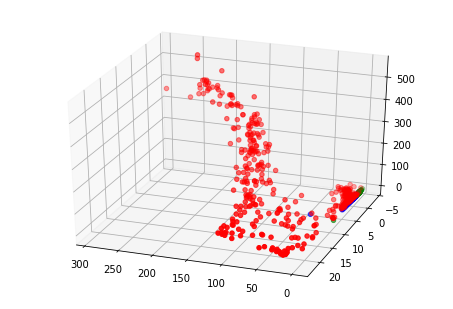

In [335]:
data = np.float32(np.concatenate((train, df_healthy, df_failure)))
colors = ["blue"] * train.shape[0]
colors.extend(["green"] * df_healthy.shape[0])
colors.extend(["red"] * df_failure.shape[0])

fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(azim=110)
ax.scatter(data[:, 0], data[:, 3], data[:, 4], c=colors)
labels = range(train.shape[0] + df_healthy.shape[0]* df_failure.shape[0])
#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

/home/johnny/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


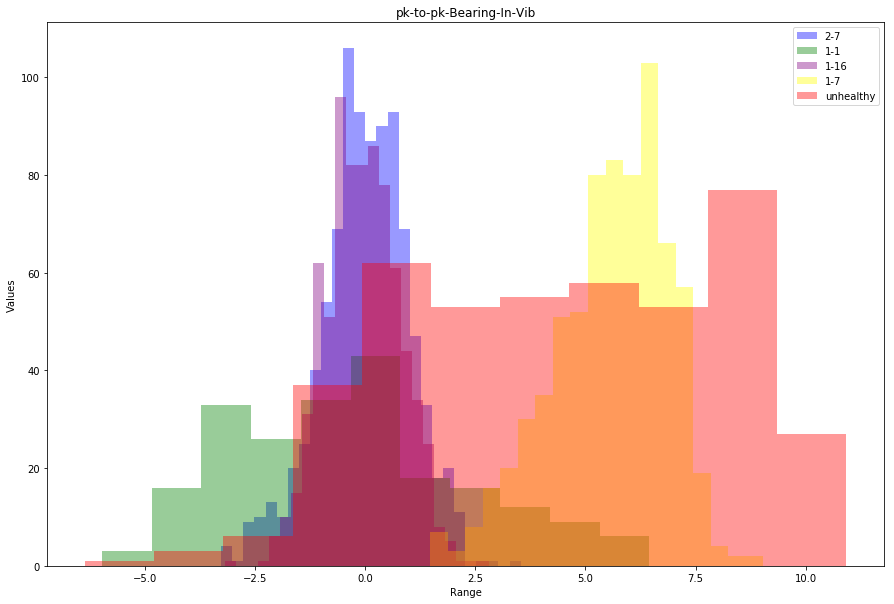

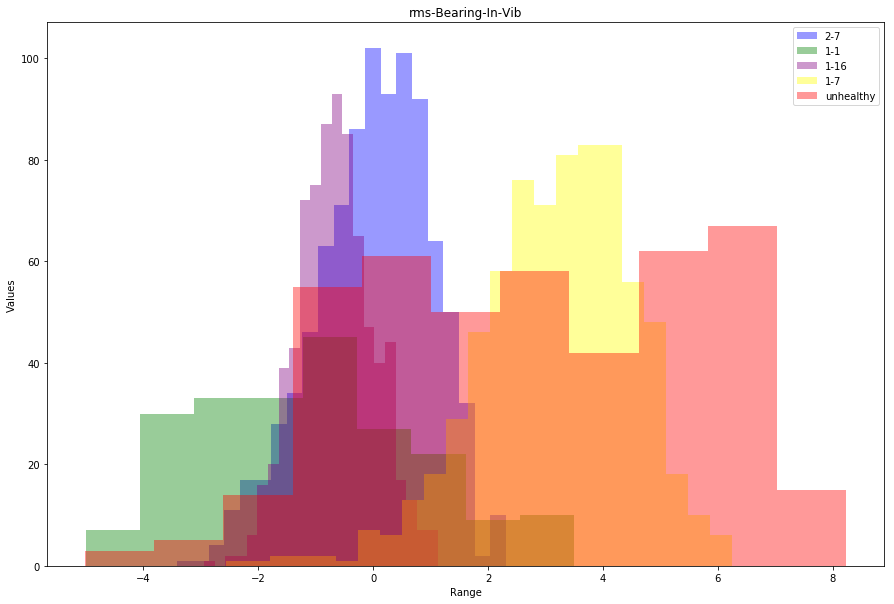

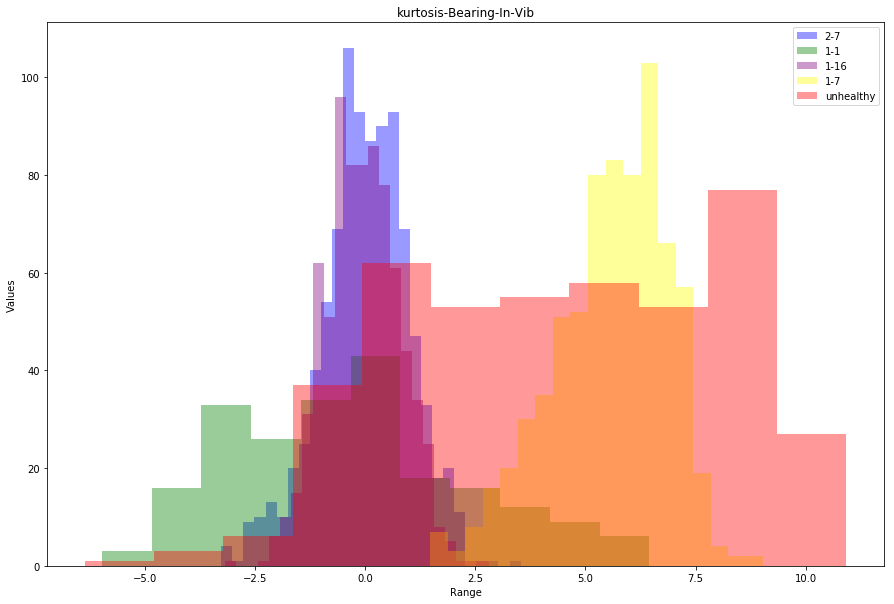

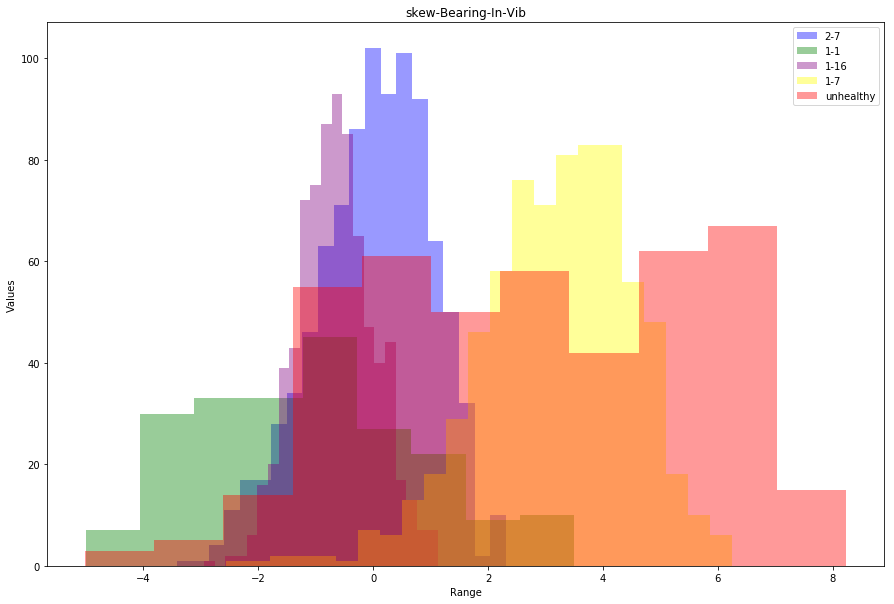

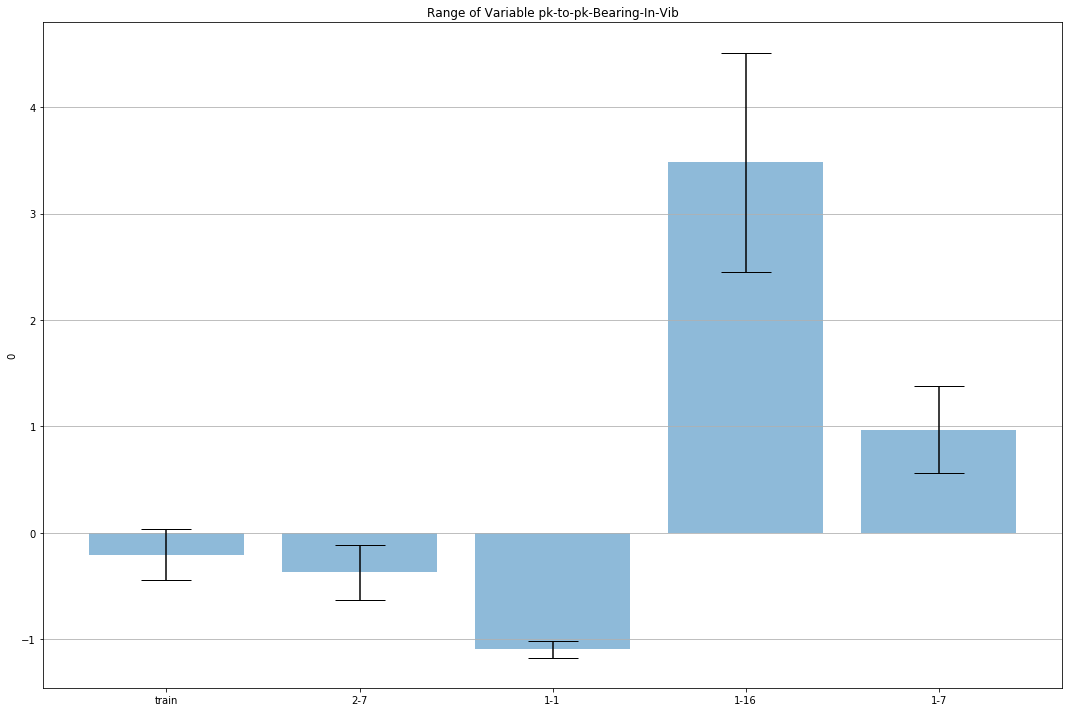

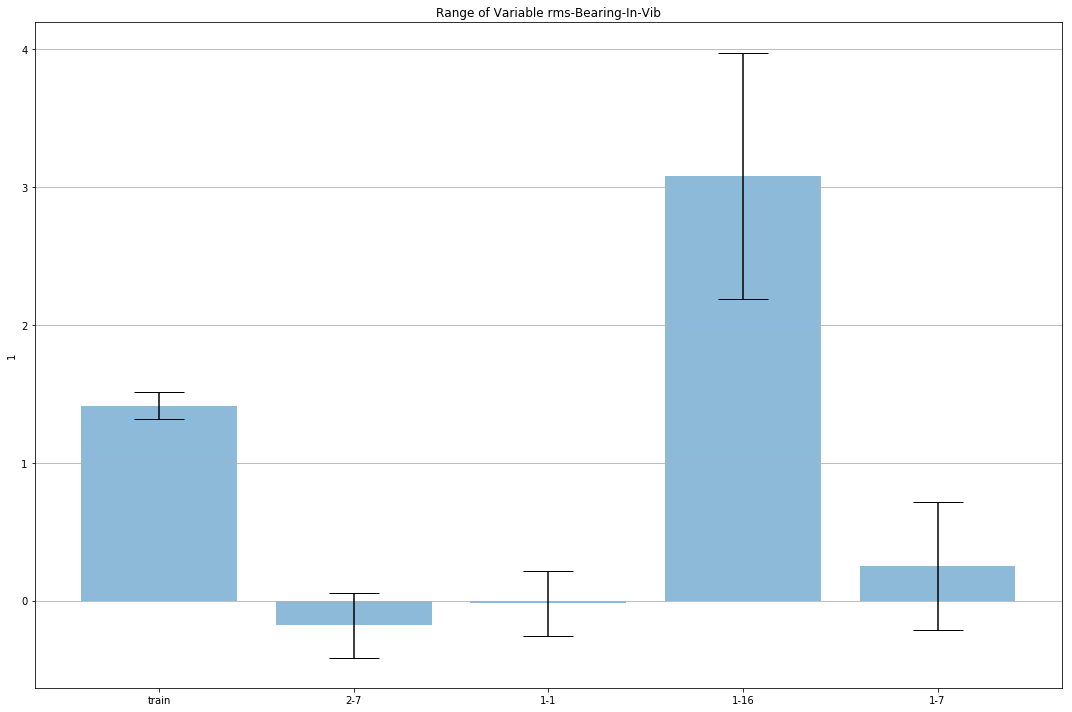

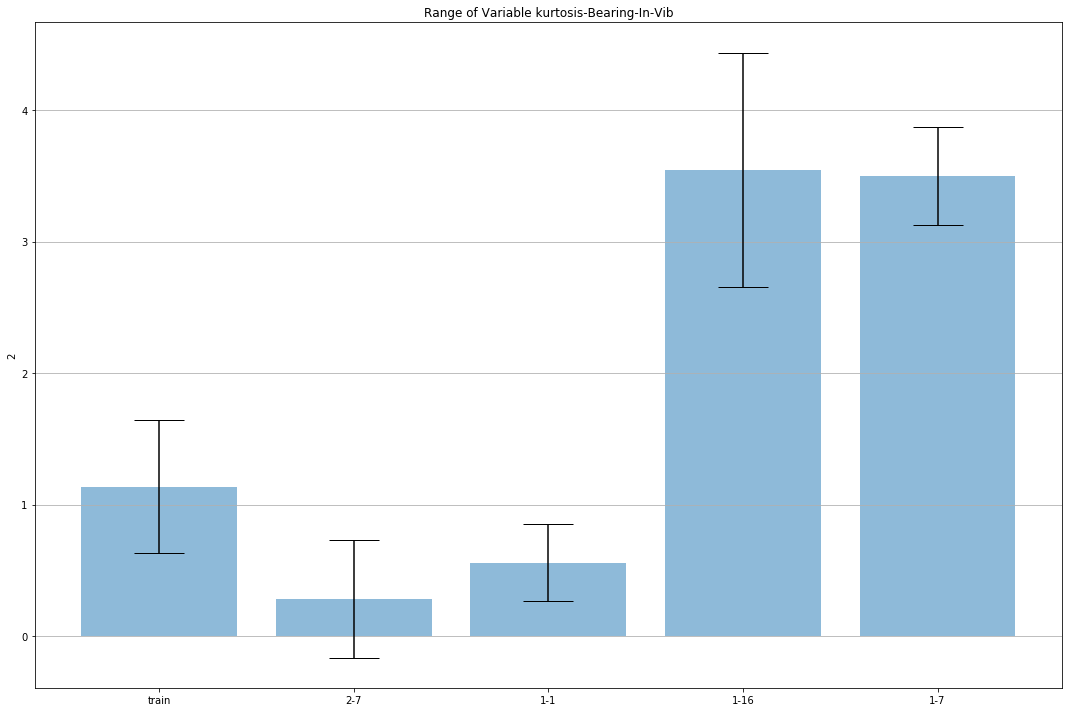

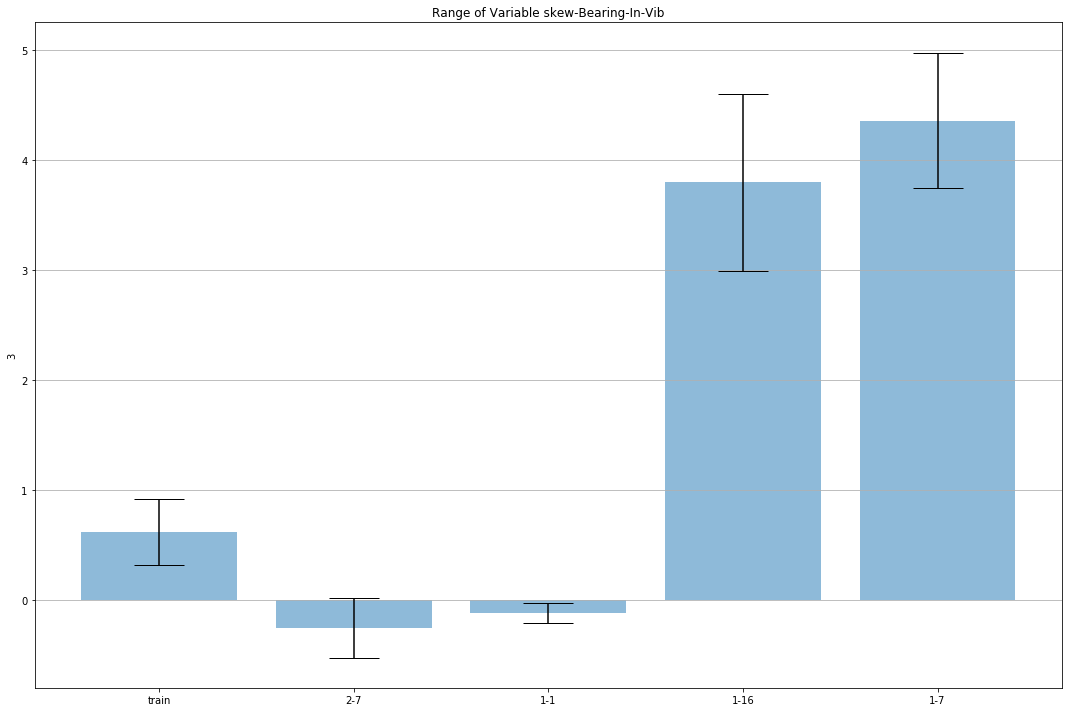

In [418]:
import seaborn as sns

sel = [14,15,22,30] #[0,1,2,3,4,14,15,16,17,20,22,24,25,28,30]

dfs = [train, df_healthy, df2, df3, df_failure]
dataset_labels = ['train', '2-7', '1-1', '1-16', '1-7', 'failure']

for col in range(0, train.shape[1]):
    plt.figure(figsize=(15,10))
    sns.distplot(train[:,col], color = 'blue', kde=False, label='2-7')
    sns.distplot(df_healthy[:,col], color = 'green', kde=False, label='1-1')
    sns.distplot(df2[:,col], color = 'purple', kde=False, label='1-16')
    sns.distplot(df3[:,col], color = 'yellow', kde=False, label='1-7')
    sns.distplot(df_failure[:,col], color = 'red', kde=False, label='unhealthy')
    plt.legend()
    plt.xlabel('Range')
    plt.ylabel('Values')
    plt.title(lookup(col))
    plt.savefig('../figs/dist-'+lookup(col)+'.png')
        
    #plt.show()
    
for col in range(0, train.shape[1]):
    mean = [np.mean(d[col]) for d in dfs]
    error = [np.std(d[col]) for d in dfs]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.bar(np.arange(len(mean)), mean, yerr=error, align='center', alpha=0.5, 
                                ecolor='black', capsize=25)
    ax.set_ylabel(col)
    ax.set_xticks(np.arange(len(mean)))
    ax.set_xticklabels(dataset_labels)
    ax.set_title('Range of Variable ' + lookup(col))
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('../figs/' + lookup(col) + '-bar.png')
        
    #plt.show()

In [407]:
train = train[:,sel]
df_healthy = df_healthy[:,sel]
df2 = df2[:,sel]
df3 = df3[:,sel]
df_failure = df_failure[:,sel]

In [408]:
m = [10,10]

In [409]:
som = SOM(m = m,dim =  train.shape[1], n_iterations=100)
som.train(train)

INFO:tensorflow:Restoring parameters from ./
Restored


In [410]:
centroids = som.get_centroids()
print(centroids['[0 0]'])

[-0.5043984   1.5888906  -0.49852458  1.5918165 ]


In [413]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
pca = PCA(n_components=3)
weights = np.zeros([m[0]*m[1], train.shape[1]])
i=0
keys = []
for key, val in centroids.items():
    keys.append(key) # need this for later
    weights[i] = val
    i+=1

colours = pca.fit_transform(weights)
sc = MinMaxScaler()
colours = sc.fit_transform(colours)
print(colours)

[[0.26574379 1.         0.67886966]
 [0.29277328 0.87655142 0.47261302]
 [0.30024485 0.77200049 0.17649512]
 [0.26136907 0.80900263 0.65387282]
 [0.21393316 0.77270235 0.00324569]
 [0.17188684 0.76150952 0.42737345]
 [0.08122701 0.81844357 0.61349581]
 [0.05518897 0.67601719 0.7016244 ]
 [0.04851232 0.54117706 0.52413415]
 [0.         0.41109648 0.4171136 ]
 [0.34423785 0.94123923 0.55157064]
 [0.3366684  0.8368983  0.09424143]
 [0.33451687 0.75303081 0.60349584]
 [0.30350732 0.71197566 0.82381153]
 [0.26602714 0.6848885  0.39284359]
 [0.21249115 0.64270216 0.27805362]
 [0.16638423 0.63012379 0.1693608 ]
 [0.12940352 0.58581105 0.39560106]
 [0.11036956 0.46439255 0.37787045]
 [0.03362455 0.25679403 0.55426249]
 [0.39987458 0.97371582 1.        ]
 [0.39066373 0.83814444 0.45176487]
 [0.36947587 0.71284833 0.37385689]
 [0.3364487  0.65448927 0.61583977]
 [0.29543351 0.60962719 0.41774086]
 [0.25543057 0.56220806 0.35123565]
 [0.22028063 0.54217538 0.40620302]
 [0.16565953 0.51596603 0.11

In [414]:
# Map inputs to their closest neurons
count = {key: 0 for key in keys}
mapped = som.map_vects(train)
for bmu in mapped:
    count[str(bmu)] += 1

list_count = [val for key, val in count.items()]
print(list_count)

[8, 9, 10, 6, 10, 11, 8, 7, 9, 14, 5, 3, 9, 3, 11, 6, 12, 9, 7, 10, 14, 10, 9, 11, 15, 11, 15, 17, 13, 4, 7, 8, 12, 10, 14, 8, 15, 14, 8, 4, 4, 10, 14, 11, 8, 6, 15, 11, 12, 7, 6, 11, 6, 10, 10, 11, 15, 12, 7, 8, 5, 5, 8, 13, 7, 7, 7, 7, 9, 8, 10, 14, 12, 14, 9, 11, 13, 12, 5, 6, 14, 13, 10, 10, 16, 7, 6, 7, 4, 4, 15, 7, 8, 7, 11, 5, 5, 4, 5, 5]


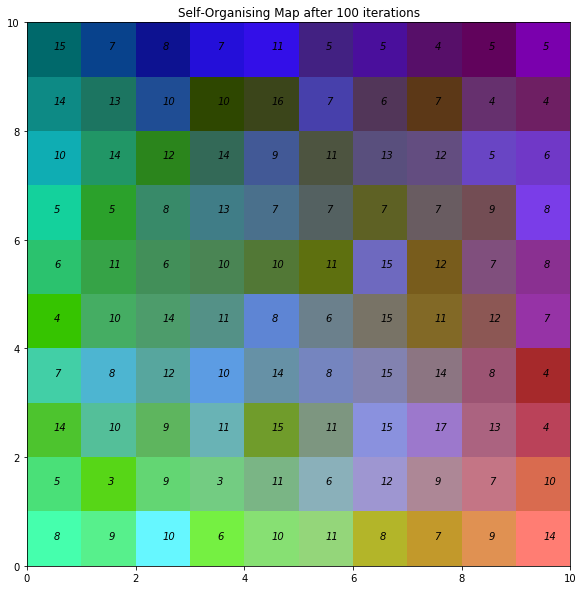

In [417]:
from matplotlib import patches as patches

# plot the rectangles
fig = plt.figure(figsize=(10,10))
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, m[0]))
ax.set_ylim((0, m[1]))
ax.set_title('Self-Organising Map after %d iterations' % 100)

i=0
for x in range(0, m[0]):
    for y in range(0, m[1]):
        ax.add_patch(patches.Rectangle((x, y), 1, 1,
                     facecolor=np.round(colours[i],2),
                     edgecolor='none'))
        ax.text(x+0.5, y+0.5, count[str(np.array([x, y]))], style='italic')
        i+=1

plt.savefig('../figs/som-colour-map.png')

plt.show()

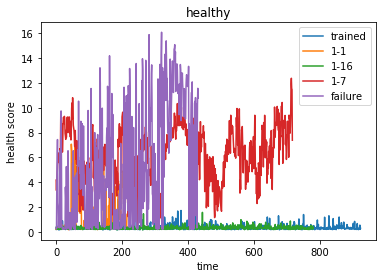

In [344]:
plt.figure(figsize=(15,10))

scores = som.health_score(train, 3, list_count, 5)
plt.plot(scores, label = 'trained')

scores = som.health_score(df_healthy, 3, list_count, 5)
plt.plot(scores, label = '1-1')

scores = som.health_score(df2, 3, list_count, 5)
plt.plot(scores, label = '1-16')

scores = som.health_score(df3, 3, list_count, 5)
plt.plot(scores, label = '1-7')

scores = som.health_score(df_failure, 3, list_count, 5)
plt.plot(scores, label = 'failure')

plt.xlabel('time')
plt.ylabel('health score')
plt.title('healthy')
plt.legend()
plt.savefig('../figs/health_score-raw.png')

plt.show()

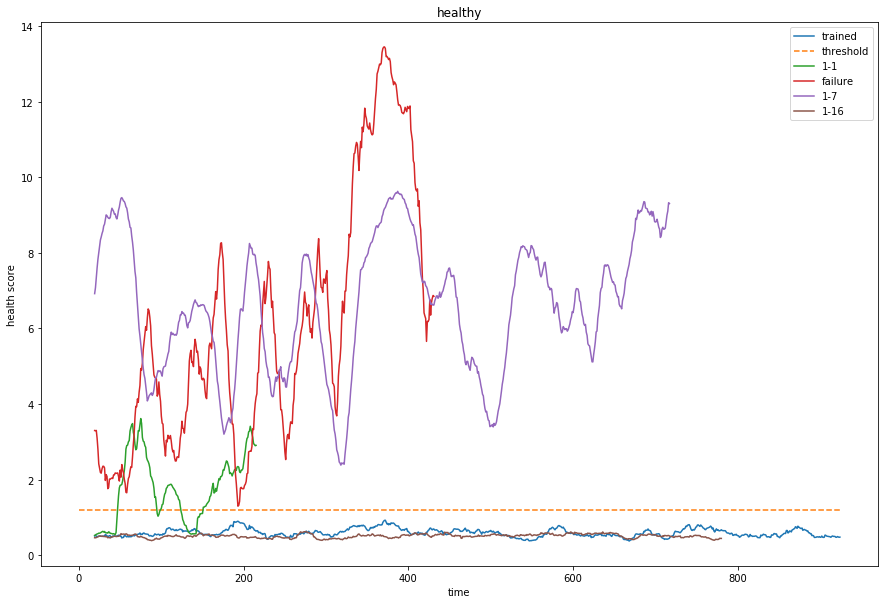

In [434]:
#from scipy.signal import savgol_filter
plt.figure(figsize=(15,10))

scores = pd.DataFrame(som.health_score(train, 3, list_count, 10))
plt.plot(scores.rolling(window=20).mean(), label = 'trained')
plt.plot([1.2]*len(scores.index), linestyle='--', label = 'threshold')

scores = pd.DataFrame(som.health_score(df_healthy, 3, list_count, 10))
plt.plot(scores.rolling(window=20).mean(), label = '1-1')

scores = pd.DataFrame(som.health_score(df_failure, 3, list_count, 10))
plt.plot(scores.rolling(window=20).mean(), label = 'failure')

scores = pd.DataFrame(som.health_score(df3, 3, list_count, 10))
plt.plot(scores.rolling(window=20).mean(), label = '1-7')

scores = pd.DataFrame(som.health_score(df2, 3, list_count, 10))
plt.plot(scores.rolling(window=20).mean(), label = '1-16')

plt.xlabel('time')
plt.ylabel('health score')
plt.title('healthy')
plt.legend()
plt.savefig('../figs/health_score-mov-avg.png')
plt.show()

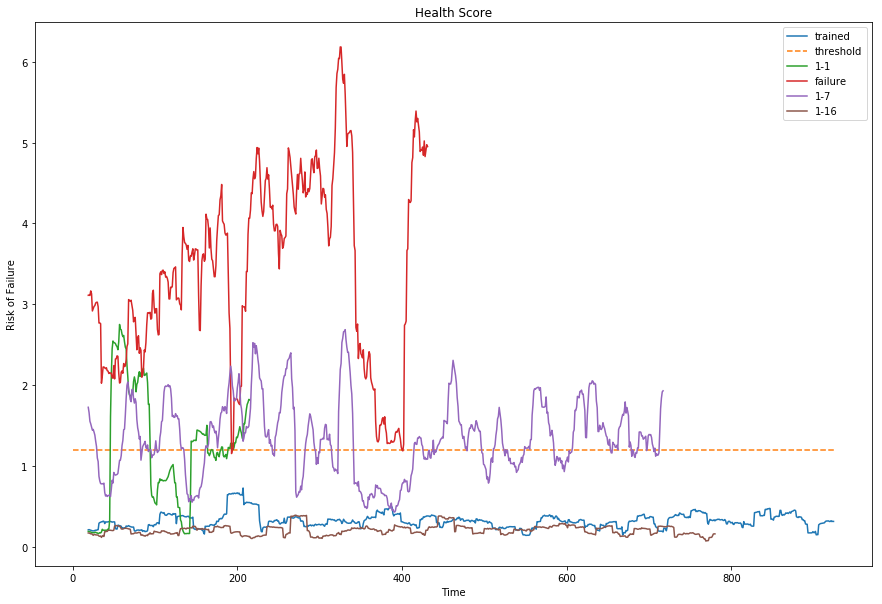

In [435]:
plt.figure(figsize=(15,10))

scores = pd.DataFrame(som.health_score(train, 3, list_count, 10))
plt.plot(scores.rolling(window=20).std(), label = 'trained')

plt.plot([1.2]*len(scores.index), linestyle='--', label = 'threshold')

scores = pd.DataFrame(som.health_score(df_healthy, 3, list_count, 10))
plt.plot(scores.rolling(window=20).std(), label = '1-1')

scores = pd.DataFrame(som.health_score(df_failure, 3, list_count, 10))
plt.plot(scores.rolling(window=20).std(), label = 'failure')

scores = pd.DataFrame(som.health_score(df3, 3, list_count, 10))
plt.plot(scores.rolling(window=20).std(), label = '1-7')

scores = pd.DataFrame(som.health_score(df2, 3, list_count, 10))
plt.plot(scores.rolling(window=20).std(), label = '1-16')




plt.xlabel('Time')
plt.ylabel('Risk of Failure')
plt.title('Health Score')
plt.legend()
plt.savefig('../figs/health_score-std.png')
plt.show()